In [ ]:
## where take the integral?
## what cell count to go with?
## why do the relative values not seem to be replicating?

In [333]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [375]:
# functions
def compute_slope(point1, point2):
    m = (point2[1]-point1[1]) / (point2[0]-point1[0])
    return m
   
def get_points(last_point, data, measure):
    prev_point = last_point - 1
    point1 = np.array((np.array(data[data['Measurement']==prev_point]['Time']), np.array(data[data['Measurement']==prev_point][measure]))).reshape(-1)
    point2 = np.array((np.array(data[data['Measurement']==last_point]['Time']), np.array(data[data['Measurement']==last_point][measure]))).reshape(-1)
    return point1, point2

def compute_b(point, slope):
    b = point[1]-(slope*point[0])
    return b

def integrate(point1, point2, slope, b):
    v2 = (0.5*slope * point2[0]**2) + (b * point2[0])
    v1 = (0.5*slope * point1[0]**2) + (b * point1[0])
    return v2-v1

def compute_integral(data, well_id, last_point, measure): 
    temp = data[data['Well']==well_id]
    point1, point2 = get_points(last_point, temp, measure)
    slope = compute_slope(point1, point2)
    b = compute_b(point1, slope)
    return integrate(point1, point2, slope, b)

from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

def plot_boxplot_by_treatment(d, y_val, colors, colors2):
    

    ax = sns.boxplot(data = d, x = 'grp', showfliers=False, y = y_val, dodge = True, order = [ 'Y622 CDP-choline', 'Y622 H2O'], palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x='grp', y=y_val, palette = colors2, dodge=True, jitter=True, alpha=1,  order = [ 'Y622 CDP-choline', 'Y622 H2O'])

    pairs = [(('Y622 H2O'), ('Y622 CDP-choline'))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x='grp', y=y_val, order = [ 'Y622 CDP-choline', 'Y622 H2O'])
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')



<Axes: xlabel='Time', ylabel='OCR'>

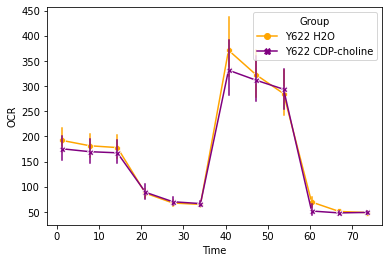

In [376]:
file_path = '../raw_data/seahorse/iN030620240_ABCA7KO_CDP-choline_04032024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

discard = set(['C03', 'C04', 'C10', 'F03', 'F04', 'F05', 'G02', 'G03' ,'G04', 'G06', 'G10', 'G11'])

df = df[[x not in discard for x in df['Well']]]

colors = dict(zip(['E3 CDP-choline', 'E3 H2O', 'G2 CDP-choline', 'G2 H2O', 'Y622 CDP-choline', 'Y622 H2O', 'Unassigned', 'Background'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink']))

df_temp = df[[x in set(['Y622 CDP-choline', 'Y622 H2O']) for x in df['Group']]]

sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation


In [377]:
T = [[compute_integral(df_temp, y, x, 'OCR') for x in range(2,13)] for y in np.unique(df_temp['Well'])]
D = np.vstack(T)
D = D.T

basal = np.sum(D[:2], axis=0)
oligomycin = np.sum(D[3:5], axis=0)
fccp = np.sum(D[6:8], axis=0)
antimycin = np.sum(D[9:11], axis=0)

df = pd.DataFrame(np.concatenate((basal.reshape(-1,1), oligomycin.reshape(-1,1), fccp.reshape(-1,1), antimycin.reshape(-1,1)), axis=1))
df.columns = ['basal', 'oligomycin', 'fccp', 'antimycin']
df['well'] = np.unique(df_temp['Well'])

dictionary = dict(zip(df_temp['Well'], df_temp['Group']))
df['grp'] = [dictionary[x] for x in df['well']]

non_mito = antimycin
true_basal = basal-non_mito
proton_leak = oligomycin - non_mito
maximal = fccp - non_mito
spare = maximal - true_basal
atp = true_basal - proton_leak

df['non_mito'] = non_mito
df['true_basal'] = true_basal
df['proton_leak'] = proton_leak
df['maximal'] = maximal
df['spare'] = spare
df['atp'] = atp
df['max_over_basal'] = maximal/true_basal
df['atp_over_basal'] = atp/true_basal
df['proton_leak_over_basal'] = proton_leak/true_basal
df['temp'] = proton_leak/atp

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 CDP-choline vs. Y622 H2O: t-test independent samples, P_val:3.583e-04 t=4.584e+00


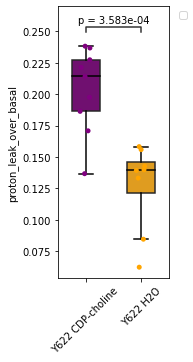

In [379]:
plt.figure(figsize=(2,5))
colors = dict(zip(['E3 CDP-choline', 'E3 H2O', 'G2 CDP-choline', 'G2 H2O', 'Y622 CDP-choline', 'Y622 H2O', 'Unassigned', 'Background'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink']))

plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors)

In [362]:
def compute_slope(point1, point2):
    m = (point2[1]-point1[1]) / (point2[0]-point1[0])
    return m
   
def get_points(last_point, data, measure):
    prev_point = last_point - 1
    point1 = np.array((np.array(data[data['Measurement']==prev_point]['Time']), np.array(data[data['Measurement']==prev_point][measure]))).reshape(-1)
    point2 = np.array((np.array(data[data['Measurement']==last_point]['Time']), np.array(data[data['Measurement']==last_point][measure]))).reshape(-1)
    return point1, point2

def compute_b(point, slope):
    b = point[1]-(slope*point[0])
    return b

def integrate(point1, point2, slope, b):
    v2 = (0.5*slope * point2[0]**2) + (b * point2[0])
    v1 = (0.5*slope * point1[0]**2) + (b * point1[0])
    return v2-v1

def compute_integral(data, well_id, last_point, measure): 
    temp = data[data['Well']==well_id]
    point1, point2 = get_points(last_point, temp, measure)
    slope = compute_slope(point1, point2)
    b = compute_b(point1, slope)
    return integrate(point1, point2, slope, b)

from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

def plot_boxplot_by_treatment(d, y_val, colors, colors2):
    

    ax = sns.boxplot(data = d, x = 'grp', showfliers=False, y = y_val, dodge = True, order = ['E3 25k', 'Y622 25k', 'G2 25k'], palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x='grp', y=y_val, palette = colors2, dodge=True, jitter=True, alpha=1,  order = ['E3 25k', 'Y622 25k', 'G2 25k'])

    pairs = [(("E3 25k"), ("Y622 25k")), (("E3 25k"), ("G2 25k"))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x='grp', y=y_val, order = ['E3 25k', 'Y622 25k', 'G2 25k'])
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')


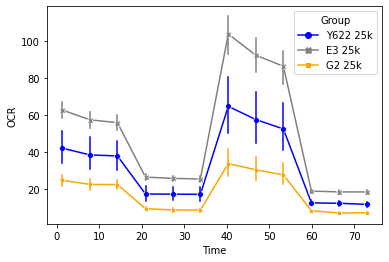

In [366]:
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024_edited.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)
colors = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'grey' , 'orange','blue']))

df.head()

df_temp = df[['25k' in x for x in df['Group']]]
df_temp = df_temp[[x not in set(['G02', 'G05', 'F02', 'F03', 'F04']) for x in df_temp['Well']]]
#df_temp = df_temp[np.invert(df_temp['Group']=='G2 25k')]
sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.savefig('../pdf_figures/seahorse_trace.pdf')

In [367]:
T = [[compute_integral(df_temp, y, x, 'OCR') for x in range(2,13)] for y in np.unique(df_temp['Well'])]
D = np.vstack(T)
D = D.T

basal = np.sum(D[1:2], axis=0)
oligomycin = np.sum(D[4:5], axis=0)
fccp = np.sum(D[7:8], axis=0)
antimycin = np.sum(D[10:11], axis=0)

df = pd.DataFrame(np.concatenate((basal.reshape(-1,1), oligomycin.reshape(-1,1), fccp.reshape(-1,1), antimycin.reshape(-1,1)), axis=1))
df.columns = ['basal', 'oligomycin', 'fccp', 'antimycin']
df['well'] = np.unique(df_temp['Well'])

dictionary = dict(zip(df_temp['Well'], df_temp['Group']))
df['grp'] = [dictionary[x] for x in df['well']]

non_mito = antimycin
true_basal = basal-non_mito
proton_leak = oligomycin - non_mito
maximal = fccp - non_mito
spare = maximal - true_basal
atp = true_basal - proton_leak

df['non_mito'] = non_mito
df['true_basal'] = true_basal
df['proton_leak'] = proton_leak
df['maximal'] = maximal
df['spare'] = spare
df['atp'] = atp
df['max_over_basal'] = maximal/true_basal
df['atp_over_basal'] = atp/true_basal
df['proton_leak_over_basal'] = proton_leak/true_basal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:3.382e-01 t=9.839e-01
E3 25k vs. G2 25k: t-test independent samples, P_val:6.212e-11 t=1.365e+01


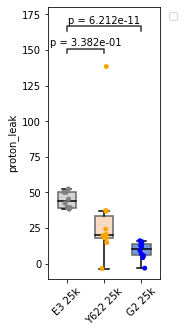

In [369]:
plt.figure(figsize=(2,5))
colors2 = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'grey' , 'blue','orange']))
colors = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'lightgrey' , 'cornflowerblue', 'peachpuff']))
plot_boxplot_by_treatment(df, 'proton_leak', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

<Axes: xlabel='Time', ylabel='OCR'>

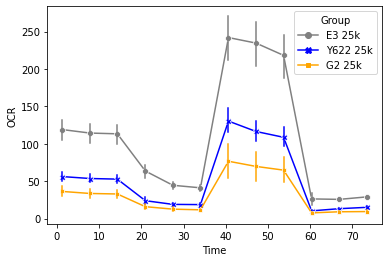

In [370]:
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03272024_iNbatch02282024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)
colors = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'grey' , 'orange','blue']))

df.head()

df_temp = df[['25k' in x for x in df['Group']]]
df_temp = df_temp[[x not in set(['B11', 'E02', 'E03', 'G02', 'G03', 'G04', 'F09', 'G08', 'G09', 'G11']) for x in df_temp['Well']]]

#df_temp = df_temp[np.invert(df_temp['Group']=='G2 25k')]
sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation


In [371]:
T = [[compute_integral(df_temp, y, x, 'OCR') for x in range(2,13)] for y in np.unique(df_temp['Well'])]
D = np.vstack(T)
D = D.T

basal = np.sum(D[1:2], axis=0)
oligomycin = np.sum(D[4:5], axis=0)
fccp = np.sum(D[7:8], axis=0)
antimycin = np.sum(D[10:11], axis=0)

df = pd.DataFrame(np.concatenate((basal.reshape(-1,1), oligomycin.reshape(-1,1), fccp.reshape(-1,1), antimycin.reshape(-1,1)), axis=1))
df.columns = ['basal', 'oligomycin', 'fccp', 'antimycin']
df['well'] = np.unique(df_temp['Well'])

dictionary = dict(zip(df_temp['Well'], df_temp['Group']))
df['grp'] = [dictionary[x] for x in df['well']]

non_mito = antimycin
true_basal = basal-non_mito
proton_leak = oligomycin - non_mito
maximal = fccp - non_mito
spare = maximal - true_basal
atp = true_basal - proton_leak

df['non_mito'] = non_mito
df['true_basal'] = true_basal
df['proton_leak'] = proton_leak
df['maximal'] = maximal
df['spare'] = spare
df['atp'] = atp
df['max_over_basal'] = maximal/true_basal
df['atp_over_basal'] = atp/true_basal
df['proton_leak_over_basal'] = proton_leak/true_basal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.029e-06 t=7.405e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.184e-05 t=6.842e+00


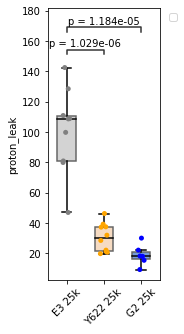

In [373]:
plt.figure(figsize=(2,5))
colors2 = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'grey' , 'blue','orange']))
colors = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'lightgrey' , 'cornflowerblue', 'peachpuff']))
plot_boxplot_by_treatment(df, 'proton_leak', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:2.616e-03 t=3.522e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:5.307e-04 t=4.565e+00


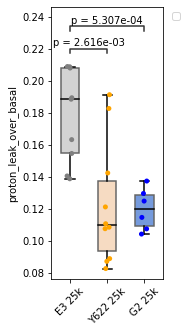

In [332]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.878e-03 t=-3.675e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.114e-01 t=-2.435e-01


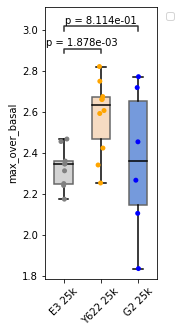

In [114]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.066e-02 t=2.868e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:2.607e-03 t=3.713e+00


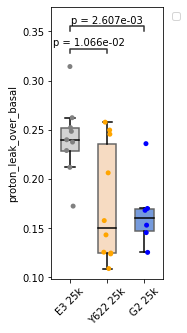

In [85]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:2.739e-03 t=3.469e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.576e-08 t=9.636e+00


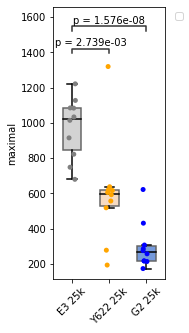

In [23]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'maximal', colors, colors2)
#plt.ylim(0,.4)
plt.savefig('../pdf_figures/maximal.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.066e-02 t=2.868e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:2.607e-03 t=3.713e+00


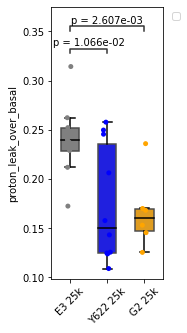

In [206]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:8.814e-02 t=1.803e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.694e-03 t=3.685e+00


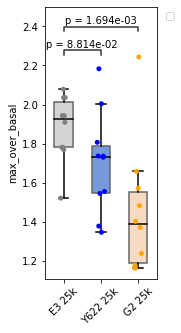

In [202]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.878e-03 t=-3.675e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.114e-01 t=-2.435e-01


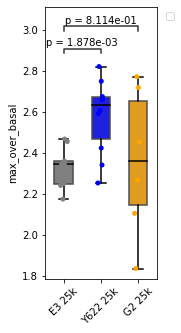

In [207]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.066e-02 t=2.868e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:2.607e-03 t=3.713e+00


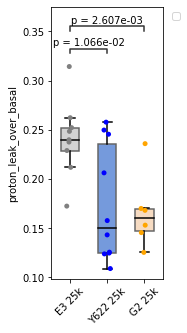

In [188]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.878e-03 t=-3.675e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.114e-01 t=-2.435e-01


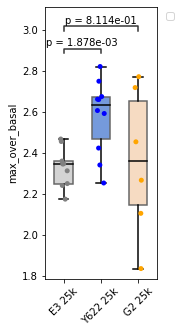

In [189]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 50k vs. Y622 50k: t-test independent samples, P_val:6.601e-01 t=4.481e-01
E3 50k vs. G2 50k: t-test independent samples, P_val:3.535e-02 t=-2.313e+00


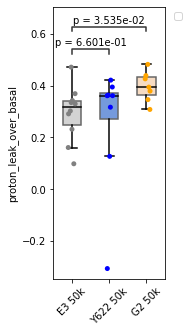

In [179]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:8.814e-02 t=1.803e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.694e-03 t=3.685e+00


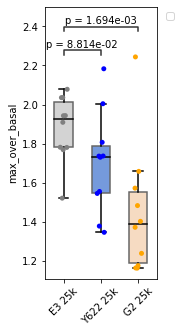

In [168]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:9.958e-01 t=5.279e-03
E3 25k vs. G2 25k: t-test independent samples, P_val:9.196e-06 t=6.100e+00


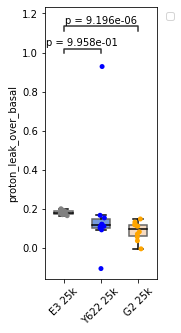

In [169]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.878e-03 t=-3.675e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.114e-01 t=-2.435e-01


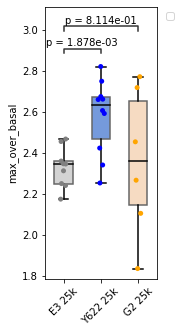

In [164]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.645e-02 t=2.645e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:4.743e-01 t=-7.308e-01


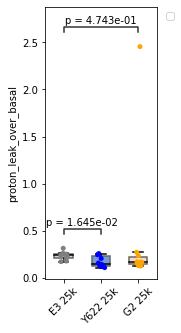

In [119]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:9.958e-01 t=-5.279e-03
E3 25k vs. G2 25k: t-test independent samples, P_val:9.196e-06 t=-6.100e+00


(0.0, 1.0)

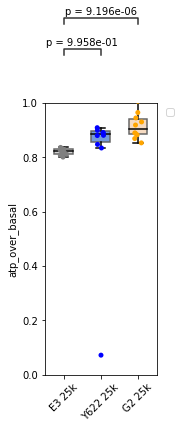

In [123]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'atp_over_basal', colors, colors2)
plt.ylim(0,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.645e-02 t=-2.645e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:4.743e-01 t=7.308e-01


(0.0, 1.0)

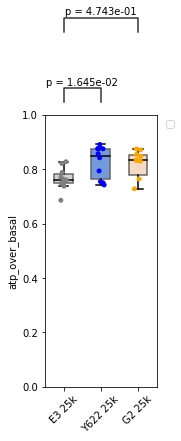

In [116]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'atp_over_basal', colors, colors2)
plt.ylim(0,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:8.814e-02 t=1.803e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.694e-03 t=3.685e+00


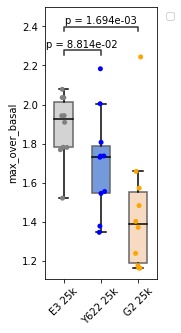

In [92]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)

In [65]:
plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)

ValueError: Could not interpret input 'grp'

<Figure size 144x360 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.116e-02 t=2.827e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.238e-09 t=1.135e+01


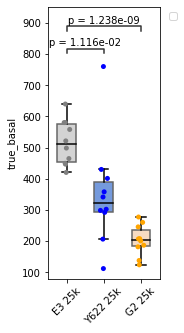

In [243]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'true_basal', colors, colors2)

array([325.2681095 , 669.12336741, 360.52118361, 181.49424014,
       123.7749771 , 265.59035273, 358.4786103 , 304.09568361,
        20.97727813, 255.89892501, 470.49336678, 530.51793004,
       421.41756668, 478.78877446, 370.13077138, 382.77899213,
       413.95519459, 466.57787969, 342.67755155, 357.62171081,
       225.82304792, 218.08412233, 196.20854585, 166.03363844,
       199.64624075, 138.51836153, 176.95115049, 257.78749913,
       154.85784452, 113.66816518])

In [239]:
np.argwhere((atp/true_basal)>1)

array([[ 4],
       [25]])

In [241]:
df.iloc[4]

basal                     257.586944
oligomycin                133.811967
fccp                      339.287465
antimycin                 145.775797
well                             B11
grp                         Y622 25k
non_mito                  145.775797
true_basal                111.811147
proton_leak                -11.96383
maximal                   193.511668
spare                      81.700521
atp                       123.774977
max_over_basal              1.730701
atp_over_basal                 1.107
proton_leak_over_basal        -0.107
Name: 4, dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:9.958e-01 t=-5.279e-03
E3 25k vs. G2 25k: t-test independent samples, P_val:9.196e-06 t=-6.100e+00


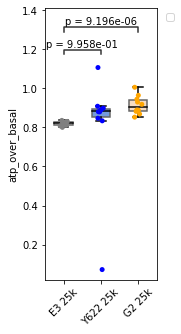

In [235]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'atp_over_basal', colors, colors2)

In [136]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

def plot_boxplot_by_treatment(d, y_val, colors, colors2):
    

    ax = sns.boxplot(data = d, x = 'Group', showfliers=False, y = y_val, dodge = True, order = ['E3 25k', 'Y622 25k', 'G2 25k'], palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x='grp', y=y_val, palette = colors2, dodge=True, jitter=True, alpha=1,  order = ['E3 25k', 'Y622 25k', 'G2 25k'])

    pairs = [(("E3 25k"), ("Y622 25k")), (("E3 25k"), ("G2 25k"))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x='grp', y=y_val, order = ['E3 25k', 'Y622 25k', 'G2 25k'])
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')


In [116]:
df_temp['Measurement']

18       1
19       1
20       1
21       1
22       1
        ..
1134    12
1135    12
1136    12
1137    12
1138    12
Name: Measurement, Length: 360, dtype: int64

In [102]:
df_temp

,Measurement,Well,Group,Time,OCR,ECAR,PER
18,1,B07,Y622 25k,1.302014,41.233374,9.248245,0
19,1,B08,Y622 25k,1.302014,76.612055,10.913393,0
20,1,B09,Y622 25k,1.302014,49.529537,12.207213,0
21,1,B10,Y622 25k,1.302014,27.093456,7.158849,0
22,1,B11,Y622 25k,1.302014,19.512938,5.763437,0
...,...,...,...,...,...,...,...
1134,12,G07,G2 25k,72.914893,6.416389,8.889256,0
1135,12,G08,G2 25k,72.914893,7.105036,10.039441,0
1136,12,G09,G2 25k,72.914893,8.069530,13.565325,0
1137,12,G10,G2 25k,72.914893,7.784274,9.537526,0


41.95861716838372

-0.5570164304084958

array([7.78831964])

In [67]:
point2[0]

114    7.78832
Name: Time, dtype: float64

In [38]:
sheet_name = 'Operation Log'  
df_log = pd.read_excel(file_path, sheet_name=sheet_name)


In [40]:
df

,Measurement,Well,Group,Time,OCR,ECAR,PER
0,1,A01,Background,1.302014,0.0,0.0,0
1,1,A02,Background,1.302014,0.0,0.0,0
2,1,A03,Background,1.302014,0.0,0.0,0
3,1,A04,Background,1.302014,0.0,0.0,0
4,1,A05,Background,1.302014,0.0,0.0,0
...,...,...,...,...,...,...,...
1147,12,H08,Background,72.914893,0.0,0.0,0
1148,12,H09,Background,72.914893,0.0,0.0,0
1149,12,H10,Background,72.914893,0.0,0.0,0
1150,12,H11,Background,72.914893,0.0,0.0,0


In [39]:
df_log

,Instruction Name,Command Name,Command Index,Start Time,End Time,Completion Status
0,Home,Home,0,3/13/2024 2:10:23 PM,3/13/2024 2:10:28 PM,Success
1,Load Cartridge,LoadProbes,0,3/13/2024 2:10:28 PM,3/13/2024 2:12:38 PM,Success
2,Initialization,Calibrate,1,3/13/2024 2:12:38 PM,3/13/2024 2:33:07 PM,Success
3,PreCalibration,PreCalibrate,1,3/13/2024 2:12:39 PM,3/13/2024 2:25:55 PM,Success
4,OffsetCalibrate,OffsetCalibrate,1,3/13/2024 2:25:59 PM,3/13/2024 2:26:22 PM,Success
5,CoarseCalibrate,CoarseCalibrate,1,3/13/2024 2:25:59 PM,3/13/2024 2:29:18 PM,Success
6,FineCalibrate,FineCalibrate,1,3/13/2024 2:29:18 PM,3/13/2024 2:33:03 PM,Success
7,Load Plate,LoadPlate,0,3/13/2024 2:33:07 PM,3/13/2024 2:36:14 PM,Success
8,Equilibrate,Equilibrate,0,3/13/2024 2:36:15 PM,3/13/2024 2:48:47 PM,Success
9,Baseline,Mix,2,3/13/2024 2:48:47 PM,3/13/2024 2:51:54 PM,Success


<Axes: xlabel='Time', ylabel='OCR'>

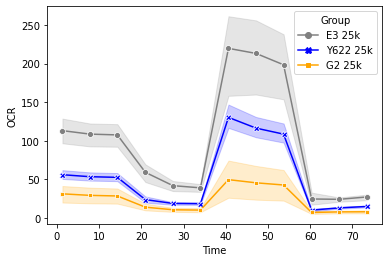

In [34]:
file_path = '../raw_data/seahorse/iN_ABCA7KO_25k_25k_03272024_iNbatch02282024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

df.head()

df_temp = df[['25k' in x for x in df['Group']]]

sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95)#, #err_style='bars')  # 68% CI for roughly one standard deviation


,Measurement,Well,Group,Time,OCR,ECAR,PER
0,1,A01,Background,1.302014,0.0,0.0,0
1,1,A02,Background,1.302014,0.0,0.0,0
2,1,A03,Background,1.302014,0.0,0.0,0
3,1,A04,Background,1.302014,0.0,0.0,0
4,1,A05,Background,1.302014,0.0,0.0,0


In [10]:
np.unique(df['Group'])

array(['Background', 'E3 25k', 'E3 50k', 'G2 25k', 'G2 50k', 'Y622 25k',
       'Y622 50k'], dtype=object)

<Axes: xlabel='Time', ylabel='OCR'>

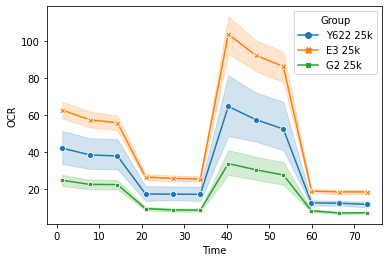

<Axes: xlabel='Time', ylabel='OCR'>

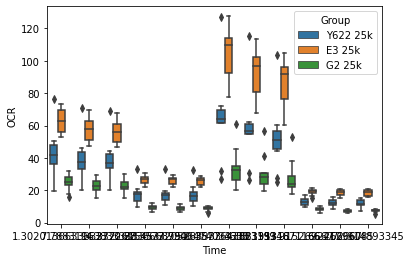

In [24]:
sns.boxplot(data = df_temp, x = 'Time', y = 'OCR', hue = 'Group')

In [17]:
help(sns.lineplot)

Help on function lineplot in module seaborn.relational:

lineplot(*, x=None, y=None, hue=None, size=None, style=None, data=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, dashes=True, markers=None, style_order=None, units=None, estimator='mean', ci=95, n_boot=1000, seed=None, sort=True, err_style='band', err_kws=None, legend='auto', ax=None, **kwargs)
    Draw a line plot with possibility of several semantic groupings.
    
    The relationship between ``x`` and ``y`` can be shown for different subsets
    of the data using the ``hue``, ``size``, and ``style`` parameters. These
    parameters control what visual semantics are used to identify the different
    subsets. It is possible to show up to three dimensions independently by
    using all three semantic types, but this style of plot can be hard to
    interpret and is often ineffective. Using redundant semantics (i.e. both
    ``hue`` and ``style`` for the same variable) can be help